In [141]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas import *
from pandas_datareader import data as pdr
import tensorflow as tf
import seaborn as sns
yf.pdr_override()
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [277]:
def data_load(startdate='2015-1-1', train_end='2017-12-31', test_start='2018-01-01', enddate='2018-12-31', verbose=0):
    # Tickers
    tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X']

    # data Close
    data_close = pdr.get_data_yahoo(tickers, start=startdate, end=enddate)['Adj Close']
    if verbose:
        print('\n--- Full dataset')
        display(data_close)

    # data returns
    data = data_close.shift(1) / data_close - 1
    if verbose:
        print('\n--- Full dataset returns')
        display(data)

    # Sets
    data_train = data[startdate:train_end].dropna()
    data_test = data[test_start:enddate].dropna()
    if verbose:
        print('\n--- Train set unadjusted')
        display(data_train)
        print('\n--- Test set unadjusted')
        display(data_test)

    # mu sigma train
    mu_train = data_train.mean()
    sigma_train = data_train.std()
    if verbose:
        print('\n--- mu train:')
        display(pd.DataFrame(mu_train, columns=['Train set Mean']))
        print('\n--- sigma train:')
        display(pd.DataFrame(sigma_train, columns=['Train set st dev']))

    # Final sets
    data_train_prod = (data_train - mu_train) / sigma_train
    data_test_prod = (data_test - mu_train) / sigma_train
    if verbose:
        print('\n--- Train set adjusted')
        display(data_train_prod)
        print('\n--- Test set adjusted')
        display(data_test_prod)
    
    return data_train_prod, data_test_prod

data_train_prod, data_test_prod = data_load()

[*********************100%***********************]  8 of 8 completed


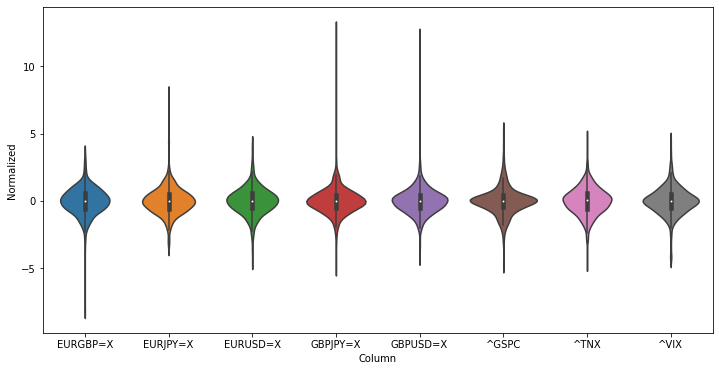

In [143]:
df_std = data_train_prod.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)

In [144]:
print(list(data_train_prod.columns))

['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X', '^GSPC', '^TNX', '^VIX']


In [264]:
def evaluate_model(model, hist, inputs, labels, test_inputs, test_labels, acc=False, verbose=0):
    # Classification Logic
    if acc:
        display_columns = ['Naive (Train)', 'Naive (Test)', 'HITS (Train)', 'HITS (Val)']
        df = pd.DataFrame([], columns=display_columns)
        # Training
        pred = np.squeeze(model.predict(inputs))
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        hits = np.sum(pred == labels)/len(labels)
        naive_hits = np.sum(labels[1:] == labels[:-1])/(len(labels-1))
        
        # Validation
        pred_test = np.squeeze(model.predict(test_inputs))
        pred_test[pred_test >= 0.5] = 1
        pred_test[pred_test < 0.5] = 0
        test_hits = np.sum(pred_test == test_labels)/len(test_labels)
        naive_hits_test = np.sum(test_labels[1:] == test_labels[:-1])/(len(test_labels-1))
        
        df = df.append({key: val for key,val in zip(display_columns, 
                                                    [naive_hits, 
                                                     naive_hits_test, 
                                                     hits, 
                                                     test_hits])},
                      ignore_index=True)        
        
        #print(f'train hits: {hits} \n Test hits: {test_hits}')
        
    # Regression Logic
    else:
        display_columns = ['Naive (Train)', 'Naive (Test)', 'MASE (Train)', 'MASE (Val)']
        df = pd.DataFrame([], columns=display_columns)
        # Training
        naive_mae = mean_absolute_error(labels[1:], labels[:-1])
        std_mae = np.std(np.abs(np.squeeze(model.predict(inputs)) - labels))
        model_mae = mean_absolute_error(np.squeeze(model.predict(inputs)), labels) 
        mase = model_mae/naive_mae
        mase_std = std_mae/naive_mae
        #print('train', naive_mae, model_mae, std_mae, naive_mae, model_mae/naive_mae)
        
        # Validation
        naive_mae_test = mean_absolute_error(test_labels[1:], test_labels[:-1])
        std_mae_test = np.std(np.abs(np.squeeze(model.predict(test_inputs)) - test_labels))
        model_mae_test = mean_absolute_error(np.squeeze(model.predict(test_inputs)), test_labels)
        mase_test = model_mae_test/naive_mae_test
        mase_std_test = std_mae_test/naive_mae_test
        #print('test', model_mae_test, std_mae_test, naive_mae_test, mase_test)
        
        df = df.append({key: val for key,val in zip(display_columns, 
                                                    [naive_mae, naive_mae_test, 
                                                     f'{mase:0.2f} ({mase_std:0.2f})', 
                                                     f'{mase_test:0.2f} ({mase_std_test:0.2f})'])},
                      ignore_index=True)
    plt.figure()
    if verbose:
        plt.scatter(np.squeeze(model.predict(inputs)), labels)
        plt.title('training')
        plt.xlabel('prediction')
        plt.subplots()
        plt.scatter(np.squeeze(model.predict(test_inputs)), test_labels)
        plt.title('testing')
        plt.xlabel('prediction')
    pd.DataFrame(hist.history).plot()
    plt.show()
    return df

In [265]:
def window_data(data, window_size):
    last_index = len(data)-window_size
    
    trunc_data = [data[i:i+window_size] for i in range(last_index)]
    return np.dstack(trunc_data)
    
def gen_data(train, window, val, col=0, cls=False):
    val_data = train[-window:].append(val).values
    inputs = np.transpose(window_data(train.values, window), (2,0,1))
    labels = train.values[window:,col]
    val_inputs = np.transpose(window_data(val_data, window), (2,0,1))
    val_labels = val_data[window:,col]
    
    if cls==True:
        labels = labels > 0
        val_labels = val_labels > 0
        labels = labels.astype(int)
        val_labels = val_labels.astype(int)
    return (inputs,labels), (val_inputs, val_labels)

In [266]:
def run_wrapper(model, window, train, test, loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(1e-3), cls=False, truth_idx=0, verbose=0, epochs=50):
    tf.random.set_seed(1234)
    # if cls = True, runs HITS instead of MAE
    model.compile(loss=loss, optimizer=optimizer)
    if verbose:
        model.summary()
    
    train, val = gen_data(train, window, test, cls=cls, col=truth_idx)
    hist = model.fit(*train, epochs=epochs, verbose=0, validation_data=val)
    data = evaluate_model(model, hist, *train, *val, acc=cls)
    return data

In [279]:
def yearly_rolling_wrapper(model, window, start_year, end_year, cols, loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(1e-3), cls=False, truth_idx=0, verbose=0, epochs=50):
    year_first = '-01-01'
    year_last = '-12-31'
    all_data = pd.DataFrame([])
    for i in range(end_year-start_year+1):
        d1 = str(start_year + i) + year_first
        d2 = str(start_year + 2 + i) + year_last
        d3 = str(start_year + 3 + i) + year_first
        d4 = str(start_year + 3 + i) + year_last
        data_train, data_test = data_load(d1, d2, d3, d4)
        train = data_train.loc[:, cols]
        test = data_test.loc[:, cols]
        data = run_wrapper(model, window, train, test, loss, optimizer, cls, truth_idx, verbose, epochs)
        all_data = all_data.append(data, ignore_index=True)
    return all_data

## Index Forecasting (Conditional)

In [180]:
num_features=3
num_timesteps=1
lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

In [181]:
idx_train = data_train_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]
idx_test = data_test_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 10)                560       
_________________________________________________________________
dropout_130 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


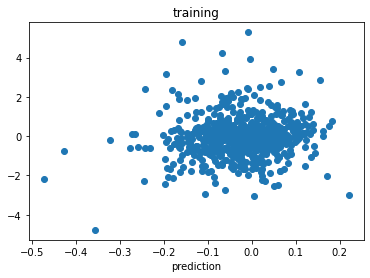

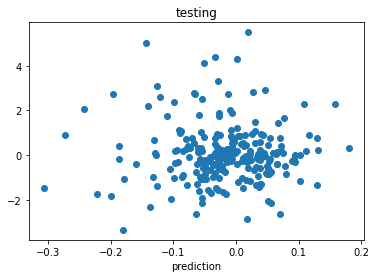

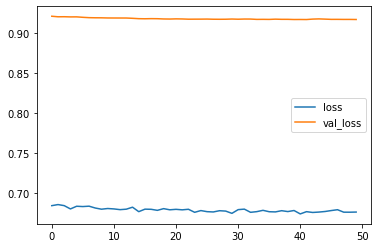

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.004346,1.247216,0.67 (0.72),0.73 (0.76)


In [182]:
window=1
lstm_model_1_data = run_wrapper(lstm_model_1, window, idx_train, idx_test, verbose=1)
lstm_model_1_data

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_132 (LSTM)              (None, 10)                560       
_________________________________________________________________
dropout_131 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


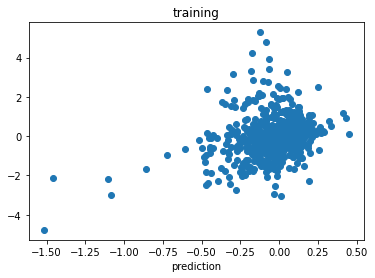

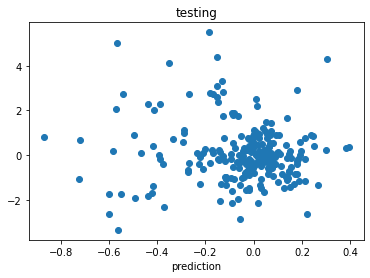

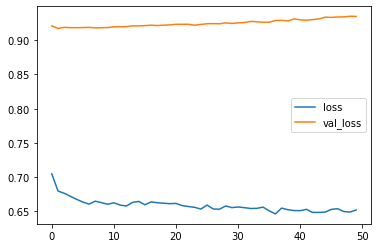

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,0.993952,1.247216,0.64 (0.71),0.75 (0.78)


In [183]:
window=16
lstm_model_16_data = run_wrapper(lstm_model_16, window, idx_train, idx_test, verbose=1)
lstm_model_16_data

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_133 (LSTM)              (None, 10)                560       
_________________________________________________________________
dropout_132 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


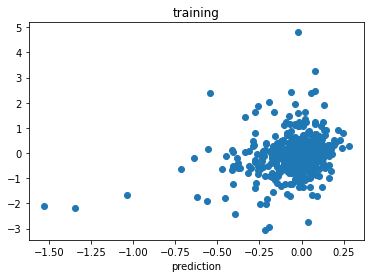

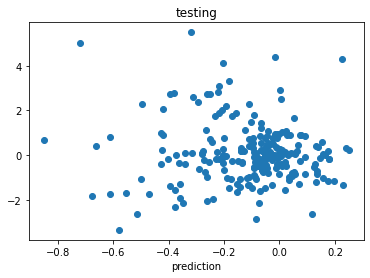

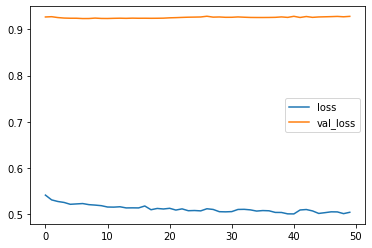

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,0.800016,1.247216,0.62 (0.70),0.74 (0.79)


In [184]:
window=256
lstm_model_256_data = run_wrapper(lstm_model_256, window, idx_train, idx_test, verbose=1)
lstm_model_256_data

## Index Forecasting (Unconditional)

## Index Forecasting Classification (Conditional)

In [185]:
num_features=3
num_timesteps=1
class_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

num_timesteps=16
class_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

num_timesteps=256
class_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

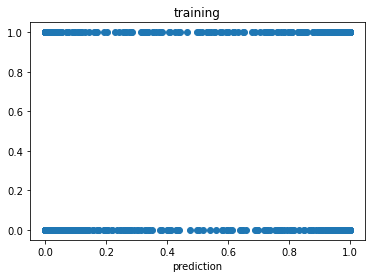

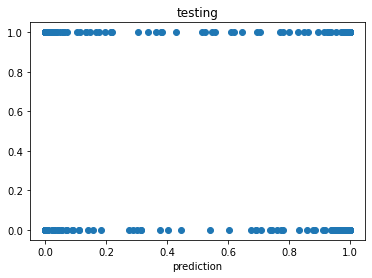

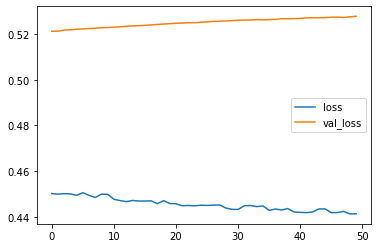

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.460251,0.518987,0.570432,0.472574


In [192]:
window=1
class_lstm_model_1_data = run_wrapper(class_lstm_model_1, window, idx_train, idx_test, cls=True)
class_lstm_model_1_data

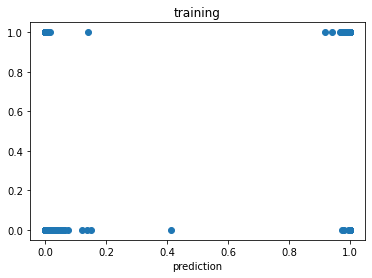

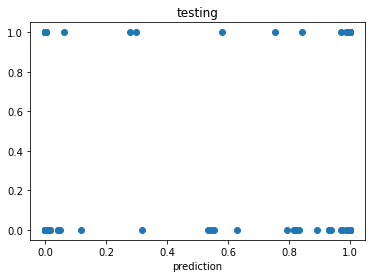

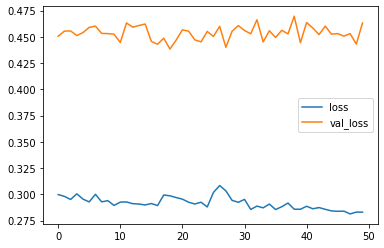

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.458689,0.518987,0.722222,0.527426


In [193]:
window=16
class_lstm_model_16_data = run_wrapper(class_lstm_model_16, window, idx_train, idx_test, cls=True)
class_lstm_model_16_data

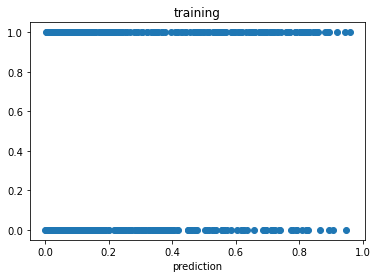

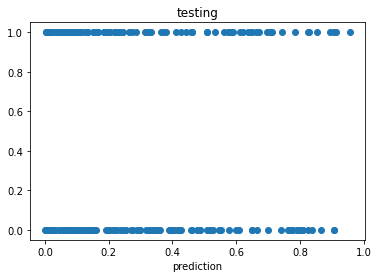

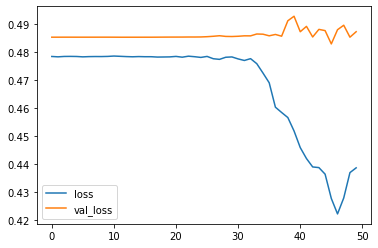

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.463203,0.518987,0.606061,0.531646


In [194]:
window=256
class_lstm_model_256_data = run_wrapper(class_lstm_model_256, window, idx_train, idx_test, cls=True)
class_lstm_model_256_data

## Index Forecasting Classification (Unconditional)

## Exchange Rate Forecasting (Conditional)

In [195]:
num_features=5
num_timesteps=1
er_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
er_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
er_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

In [196]:
er_columns = ['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X']
er_train = data_train_prod.loc[:, er_columns]
er_test = data_test_prod.loc[:, er_columns]

In [197]:
er_test.diff().abs().mean()

EURGBP=X    0.646606
EURJPY=X    0.858760
EURUSD=X    0.844043
GBPJPY=X    0.819481
GBPUSD=X    0.883561
dtype: float64

EURGBP=X


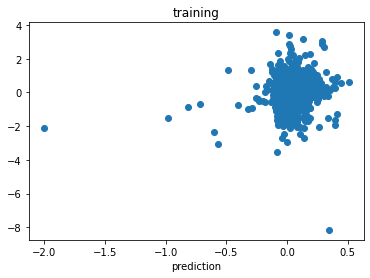

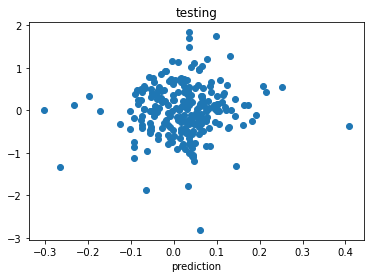

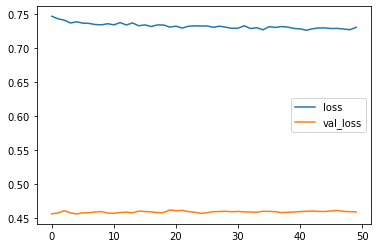

EURJPY=X


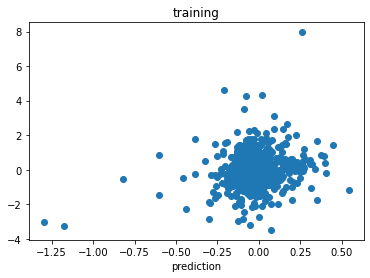

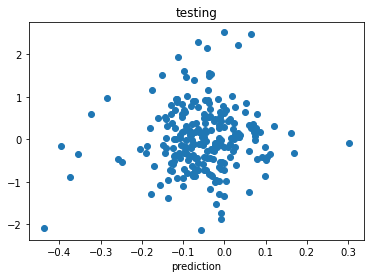

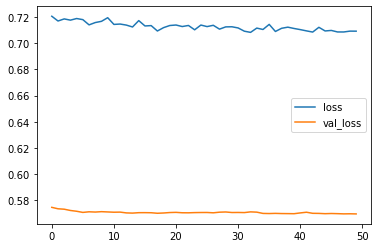

EURUSD=X


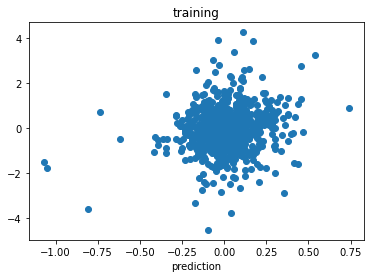

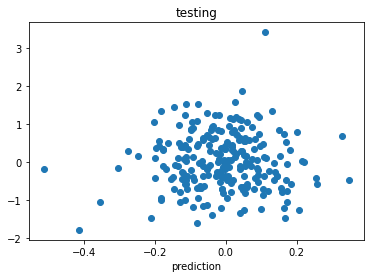

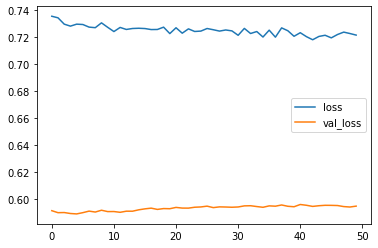

GBPJPY=X


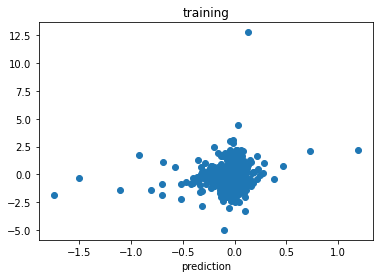

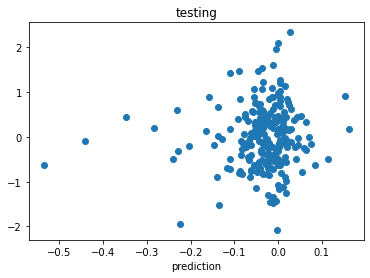

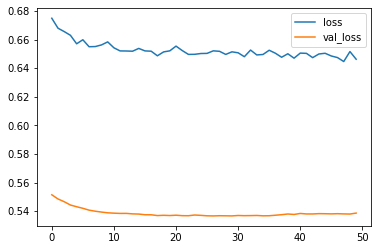

GBPUSD=X


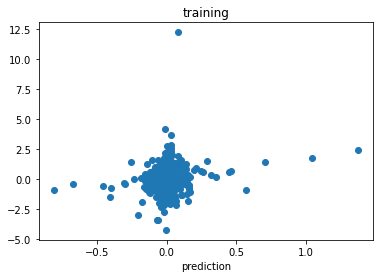

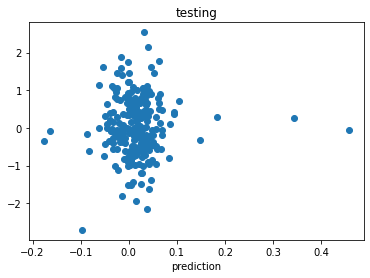

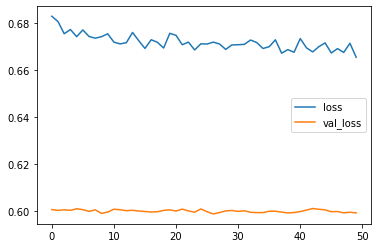

In [198]:
window=1
er_lstm_model_1_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_1, window, er_train, er_test, truth_idx=i)
    er_lstm_model_1_data = er_lstm_model_1_data.append(data)
    
er_lstm_model_1_data.index = [er_columns[i] for i in range(5)]

In [199]:
er_lstm_model_1_data

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.062889,0.646606,0.68 (0.63),0.71 (0.62)
EURJPY=X,1.075619,0.858760,0.66 (0.63),0.66 (0.58)
EURUSD=X,1.092993,0.844043,0.66 (0.61),0.70 (0.53)
GBPJPY=X,0.959938,0.819481,0.67 (0.77),0.66 (0.53)
GBPUSD=X,0.993231,0.883561,0.67 (0.73),0.68 (0.55)


EURGBP=X


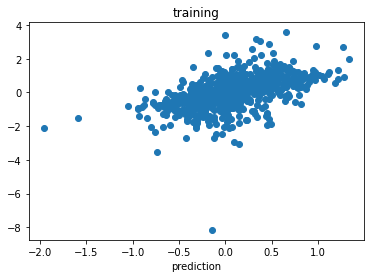

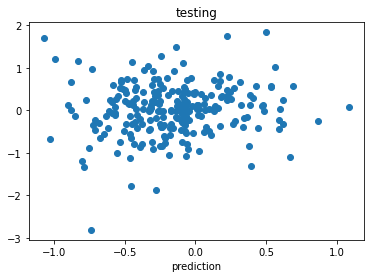

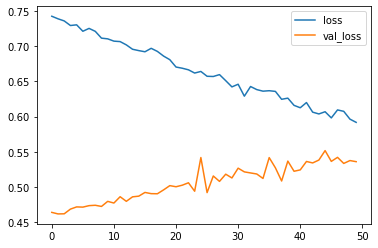

EURJPY=X


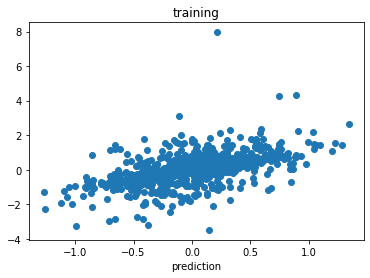

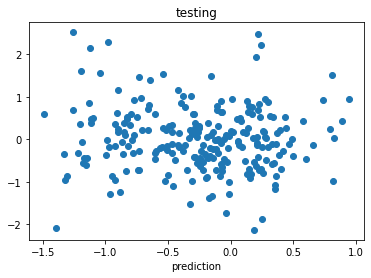

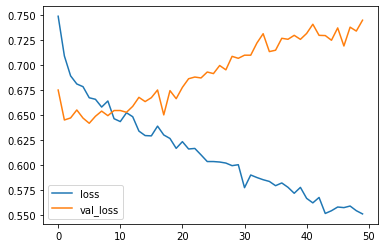

EURUSD=X


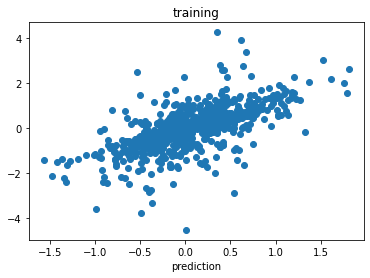

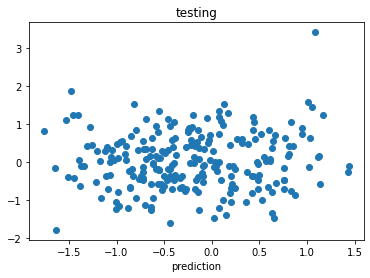

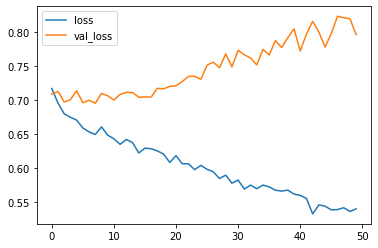

GBPJPY=X


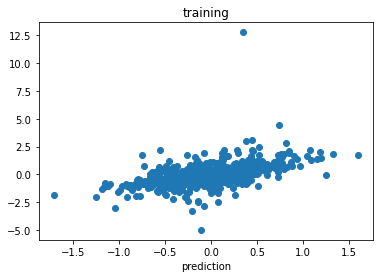

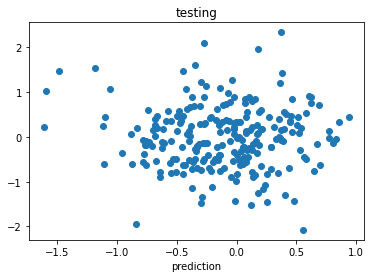

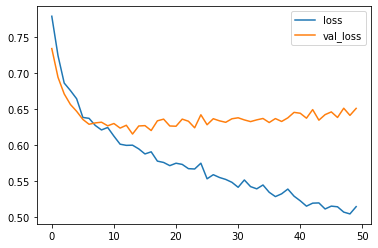

GBPUSD=X


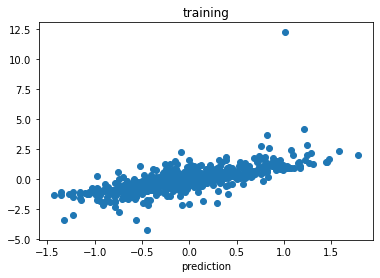

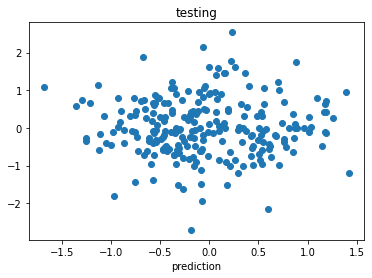

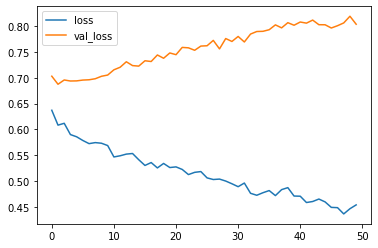

In [200]:
window=16
er_lstm_model_16_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_16, window, er_train, er_test, truth_idx=i)
    er_lstm_model_16_data = er_lstm_model_16_data.append(data)
    
er_lstm_model_16_data.index = [er_columns[i] for i in range(5)]


In [201]:
er_lstm_model_16_data

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.065658,0.646606,0.54 (0.59),0.83 (0.71)
EURJPY=X,1.055305,0.858760,0.49 (0.59),0.87 (0.74)
EURUSD=X,1.082116,0.844043,0.46 (0.53),0.94 (0.71)
GBPJPY=X,0.952392,0.819481,0.50 (0.73),0.79 (0.67)
GBPUSD=X,0.995971,0.883561,0.40 (0.61),0.91 (0.64)


EURGBP=X


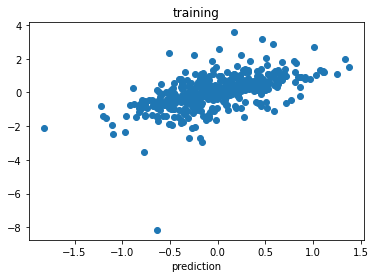

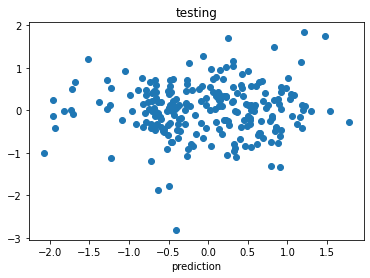

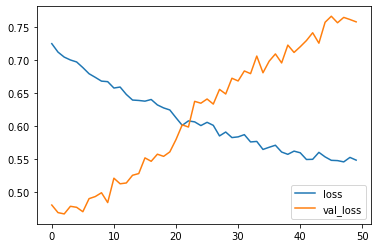

EURJPY=X


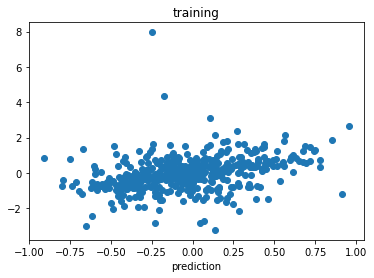

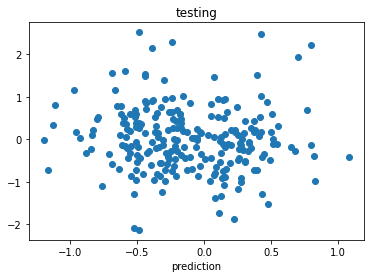

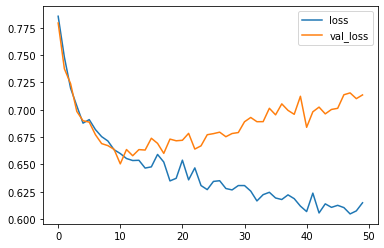

EURUSD=X


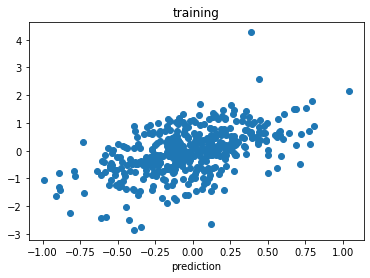

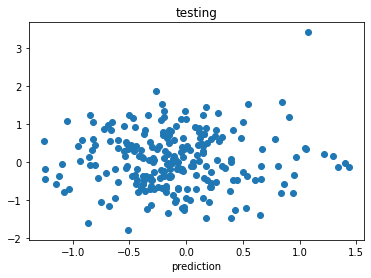

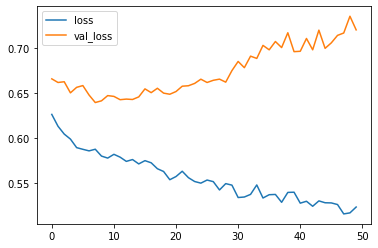

GBPJPY=X


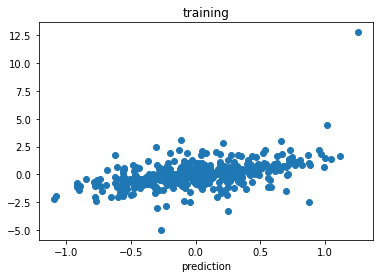

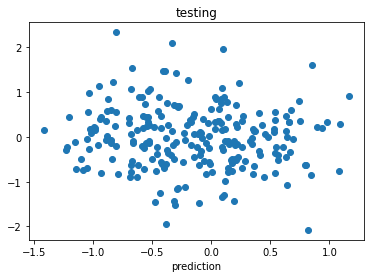

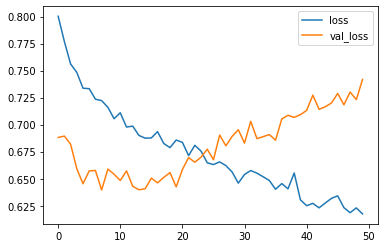

GBPUSD=X


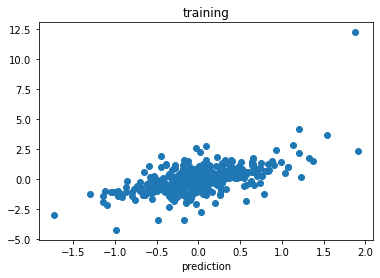

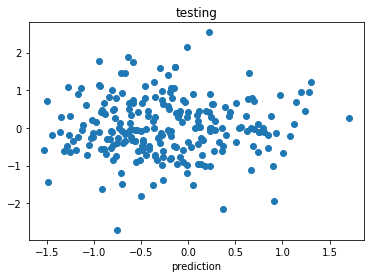

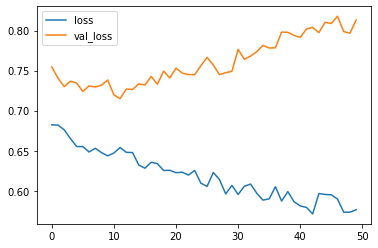

In [202]:
window=256
er_lstm_model_256_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_256, window, er_train, er_test, truth_idx=i)
    er_lstm_model_256_data = er_lstm_model_256_data.append(data)
    
er_lstm_model_256_data.index = [er_columns[i] for i in range(5)]


In [203]:
er_lstm_model_256_data

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.061233,0.646606,0.49 (0.59),1.17 (0.84)
EURJPY=X,1.043163,0.858760,0.57 (0.66),0.83 (0.65)
EURUSD=X,0.941678,0.844043,0.53 (0.52),0.85 (0.61)
GBPJPY=X,1.099582,0.819481,0.55 (0.74),0.91 (0.68)
GBPUSD=X,1.076672,0.883561,0.51 (0.66),0.92 (0.69)


## Experimentation

### S&P Regression

Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_184 (LSTM)              (None, 16, 5)             180       
_________________________________________________________________
dropout_183 (Dropout)        (None, 16, 5)             0         
_________________________________________________________________
lstm_185 (LSTM)              (None, 5)                 220       
_________________________________________________________________
dropout_184 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 6         
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


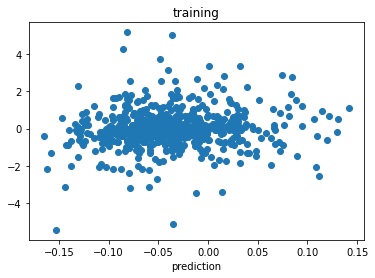

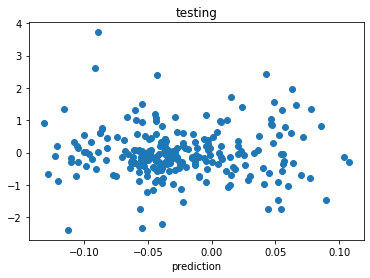

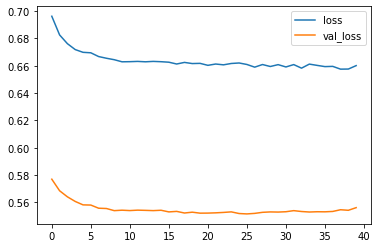

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.005709,0.816012,0.65 (0.75),0.68 (0.67)


In [262]:
num_timesteps=16
num_features=3
lstm_model_16_add_layers = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(5, kernel_regularizer=tf.keras.regularizers.l1(0.001), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(5, kernel_regularizer=tf.keras.regularizers.l1(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

window=16
lstm_model_16_add_layers_data = run_wrapper(lstm_model_16_add_layers, window, idx_train, idx_test, verbose=1, epochs=40)
lstm_model_16_add_layers_data

In [263]:
# Original data
lstm_model_16_data
# lstm_model_16 = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=(num_timesteps, num_features)),
#     tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(units=1)
# ])

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,0.993952,1.247216,0.64 (0.71),0.75 (0.78)


1. Three layers has higher starting validation error but converges to same point
2. Increasing dropout has smoother validation loss function but converges to same loss
3. Changing to l1 regularization speeds up training significantly
4. Changing loss function to MSE worsens performance
5. Increasing number of LSTM cells from 10 - 25 does not change performance
6. SGD, adagrad optimizers did not converge.

Overall, it seems like this is as much information as can be captured in the data, as the differences from changing hyperparameters or network architecture are small

### More Date Ranges

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

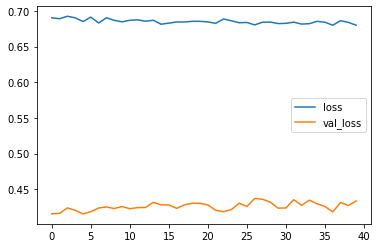

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

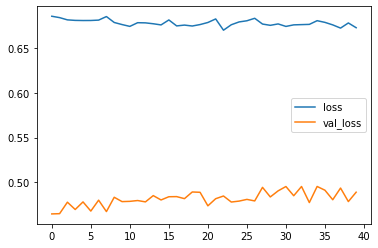

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

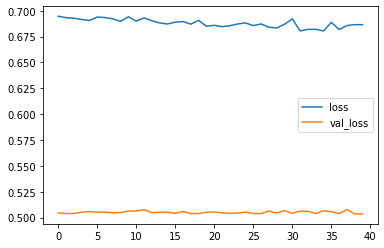

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

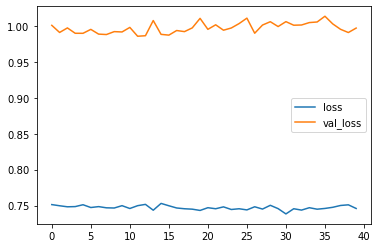

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

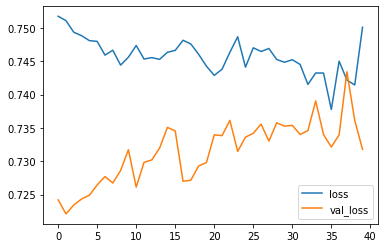

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

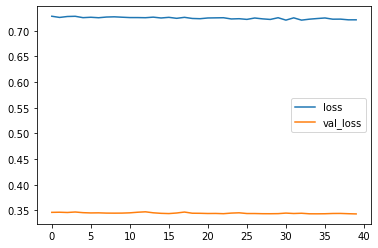

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

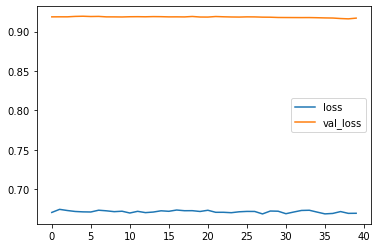

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

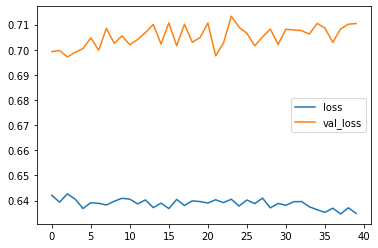

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.047777,0.614189,0.64 (0.67),0.70 (0.62)
1,1.048846,0.673409,0.64 (0.68),0.72 (0.59)
2,1.034491,0.749039,0.65 (0.69),0.66 (0.64)
3,1.122686,1.371315,0.65 (0.59),0.72 (0.66)
4,1.082464,1.093515,0.69 (0.63),0.66 (0.67)
5,1.054195,0.520765,0.68 (0.66),0.65 (0.67)
6,0.993952,1.247216,0.67 (0.73),0.73 (0.76)
7,0.923359,1.029948,0.68 (0.79),0.68 (0.71)


In [282]:
window=16
cols = ['^GSPC', '^TNX', '^VIX']
lstm_model_16_rolling_data = yearly_rolling_wrapper(lstm_model_16_add_layers, window, 2009, 2016, cols, verbose=0, epochs=40)
lstm_model_16_rolling_data

In [330]:
lstm_model_16_rolling_data = lstm_model_16_rolling_data.append(lstm_model_16_rolling_data.mean(), 'Mean')
lstm_model_16_rolling_data = lstm_model_16_rolling_data.append(lstm_model_16_rolling_data.std(), 'Std')
lstm_model_16_rolling_data.index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']
lstm_model_16_rolling_data.columns = ['Naive(Train)', 'Naive(Val)', 'MASE-Train(Std)', 'MASE-Val(Std)']
lstm_model_16_rolling_data.round(3)

,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
0,1.048,0.614,0.64 (0.67),0.70 (0.62)
1,1.049,0.673,0.64 (0.68),0.72 (0.59)
2,1.034,0.749,0.65 (0.69),0.66 (0.64)
3,1.123,1.371,0.65 (0.59),0.72 (0.66)
4,1.082,1.094,0.69 (0.63),0.66 (0.67)
5,1.054,0.521,0.68 (0.66),0.65 (0.67)
6,0.994,1.247,0.67 (0.73),0.73 (0.76)
7,0.923,1.030,0.68 (0.79),0.68 (0.71)
8,1.038,0.912,0.663,0.69
9,0.056,0.295,0.019,0.03


In [332]:
temp = lstm_model_16_rolling_data.iloc[:-2, 2:]
for col in temp:
    data = temp[col].values
    m = np.mean([float(d[:5]) for d in data])
    std = np.std([float(d[:5]) for d in data])
    lstm_model_16_rolling_data.loc['Mean', col] = np.round(m, 3)
    lstm_model_16_rolling_data.loc['Std', col] = np.round(std, 3)

lstm_model_16_rolling_data.round(3)
    

,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
0,1.048,0.614,0.64 (0.67),0.70 (0.62)
1,1.049,0.673,0.64 (0.68),0.72 (0.59)
2,1.034,0.749,0.65 (0.69),0.66 (0.64)
3,1.123,1.371,0.65 (0.59),0.72 (0.66)
4,1.082,1.094,0.69 (0.63),0.66 (0.67)
5,1.054,0.521,0.68 (0.66),0.65 (0.67)
6,0.994,1.247,0.67 (0.73),0.73 (0.76)
7,0.923,1.030,0.68 (0.79),0.68 (0.71)
8,1.038,0.912,0.663,0.69
9,0.056,0.295,0.019,0.03


In [334]:
lstm_model_16_rolling_data.index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']
lstm_model_16_rolling_data

,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.047777,0.614189,0.64 (0.67),0.70 (0.62)
2013,1.048846,0.673409,0.64 (0.68),0.72 (0.59)
2014,1.034491,0.749039,0.65 (0.69),0.66 (0.64)
2015,1.122686,1.371315,0.65 (0.59),0.72 (0.66)
2016,1.082464,1.093515,0.69 (0.63),0.66 (0.67)
2017,1.054195,0.520765,0.68 (0.66),0.65 (0.67)
2018,0.993952,1.247216,0.67 (0.73),0.73 (0.76)
2019,0.923359,1.029948,0.68 (0.79),0.68 (0.71)
Mean,1.038471,0.912424,0.663,0.69
Std,0.055585,0.294838,0.019,0.03


### S&P Classification

In [206]:
# Original Data
# class_lstm_model_16 = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=(num_timesteps, num_features)),
#     tf.keras.layers.LSTM(25, return_sequences=False),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(units=1, activation='sigmoid')
# ])
class_lstm_model_16_data

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.458689,0.518987,0.722222,0.527426


<Figure size 432x288 with 0 Axes>

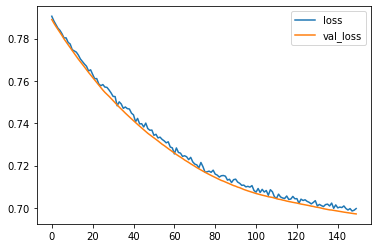

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.474227,0.53527,0.547865,0.560166


In [280]:
num_timesteps=16
num_features=3

class_lstm_model_16_add_layers = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(5, 
                         kernel_regularizer=tf.keras.regularizers.l1(.001), 
                         return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(5, 
                         kernel_regularizer=tf.keras.regularizers.l1(.001), 
                         return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(25, 
                         kernel_regularizer=tf.keras.regularizers.l1(.001), 
                         return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

window=16
class_lstm_model_16_data_add_layers = run_wrapper(class_lstm_model_16_add_layers, window, 
                                       idx_train, idx_test,
                                        optimizer=tf.keras.optimizers.Adam(1e-4),
                                        loss=tf.keras.losses.BinaryCrossentropy(),
                                        epochs=150,
                                       cls=True)
class_lstm_model_16_data_add_layers 

1. Lowering learning rate to 1e-4 showed better loss behavior, however worse HITS, perhaps MAE not best loss function for this task.
2. Changing loss to BinaryCrossEntropy(), Mean Squared Error, shows overfitting, poor performance
3. Adding Regularization (Dropout- , l2-regularization). l1-regularization significantly improved loss and performance.
4. Lowering number of LSTM cells improved performance
5. Additional layers X performance
3. Testing "best" architecture for regression seems to have poorer performance

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

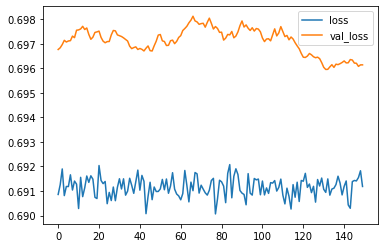

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

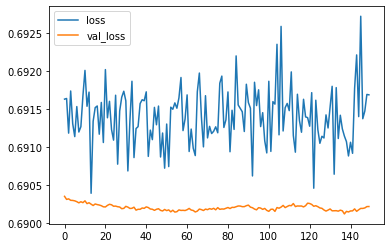

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

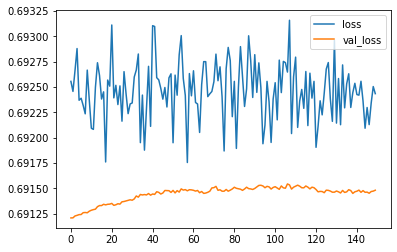

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

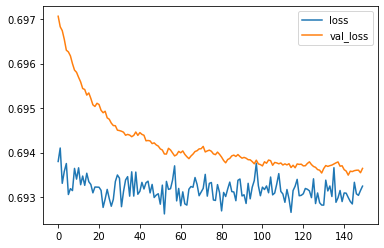

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

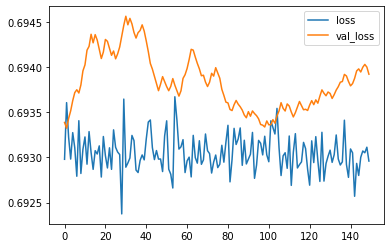

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

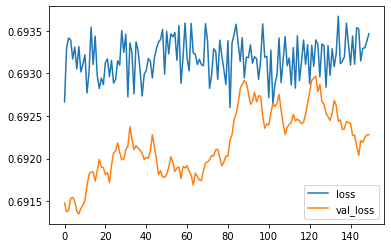

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

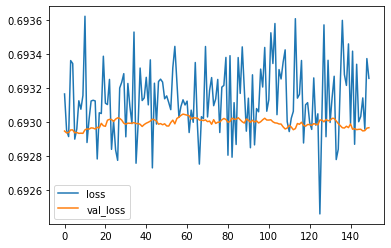

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

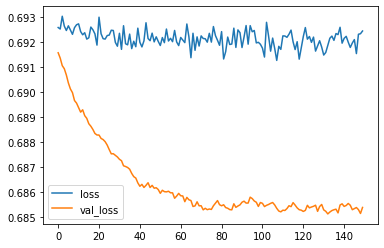

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.494334,0.525641,0.532578,0.482906
1,0.508571,0.421941,0.530000,0.540084
2,0.492109,0.451883,0.519369,0.531381
3,0.470588,0.458678,0.503587,0.458678
4,0.452482,0.456067,0.509220,0.481172
5,0.457507,0.474576,0.502833,0.559322
6,0.458689,0.518987,0.502849,0.514768
7,0.484935,0.520930,0.523673,0.595349


In [286]:
window=16
cols = ['^GSPC', '^TNX', '^VIX']
class_lstm_model_16_rolling_data = yearly_rolling_wrapper(class_lstm_model_16_add_layers, 
                                                          window, 2009, 2016, cols, 
                                                          optimizer=tf.keras.optimizers.Adam(1e-4), 
                                                          loss=tf.keras.losses.BinaryCrossentropy(), 
                                                          verbose=0, epochs=150, cls=True)
class_lstm_model_16_rolling_data

In [311]:
class_lstm_model_16_rolling_data = class_lstm_model_16_rolling_data.append(class_lstm_model_16_rolling_data.mean(), 'Mean')
class_lstm_model_16_rolling_data = class_lstm_model_16_rolling_data.append(class_lstm_model_16_rolling_data.std(), 'Std')
class_lstm_model_16_rolling_data.index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']

In [318]:
class_lstm_model_16_add_layers.summary()

Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_186 (LSTM)              (None, 16, 5)             180       
_________________________________________________________________
dropout_185 (Dropout)        (None, 16, 5)             0         
_________________________________________________________________
lstm_187 (LSTM)              (None, 16, 5)             220       
_________________________________________________________________
dropout_186 (Dropout)        (None, 16, 5)             0         
_________________________________________________________________
lstm_188 (LSTM)              (None, 25)                3100      
_________________________________________________________________
dropout_187 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 1)              

In [316]:
class_lstm_model_16_rolling_data.columns = ['Naive(Train)', 'Naive(Val)', 'HITS(Train)', 'HITS(Val)']
class_lstm_model_16_rolling_data.round(3)

,Naive(Train),Naive(Val),HITS(Train),HITS(Val)
2012,0.494,0.526,0.533,0.483
2013,0.509,0.422,0.530,0.540
2014,0.492,0.452,0.519,0.531
2015,0.471,0.459,0.504,0.459
2016,0.452,0.456,0.509,0.481
2017,0.458,0.475,0.503,0.559
2018,0.459,0.519,0.503,0.515
2019,0.485,0.521,0.524,0.595
Mean,0.477,0.479,0.516,0.520
Std,0.019,0.036,0.012,0.042


## Exchange Rate Regression

1. l1 regularization improved performance
2. 
3. 
4. 
5. 

EURGBP=X


<Figure size 432x288 with 0 Axes>

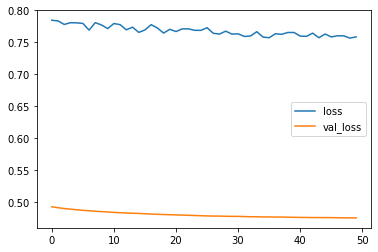

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.065658,0.646606,0.69 (0.63),0.71 (0.62)


In [359]:
num_timesteps=16
num_features=5
er_lstm_model_16_ex = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, 
                         kernel_regularizer=tf.keras.regularizers.l2(.001), 
                         return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(15, kernel_regularizer=tf.keras.regularizers.l2(.001), 
                         return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1)
])

window=16
er_lstm_model_16_data_ex = pd.DataFrame([])
for i in range(1):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_16_ex, window, er_train, er_test, truth_idx=i,
                      optimizer=tf.keras.optimizers.Adam(1e-4))
    er_lstm_model_16_data_ex = er_lstm_model_16_data_ex.append(data)
    
er_lstm_model_16_data_ex.index = [er_columns[i] for i in range(1)]
er_lstm_model_16_data_ex


In [354]:
# Saved Model
# er_lstm_model_16_ex = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=(num_timesteps, num_features)),
#     tf.keras.layers.LSTM(10, 
#                          kernel_regularizer=tf.keras.regularizers.l2(.001), 
#                          return_sequences=True),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.LSTM(15, kernel_regularizer=tf.keras.regularizers.l2(.001), 
#                          return_sequences=False),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(units=1)
# ])
er_lstm_model_16_ex.summary()

Model: "sequential_136"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_182 (LSTM)              (None, 16, 5)             220       
_________________________________________________________________
dropout_181 (Dropout)        (None, 16, 5)             0         
_________________________________________________________________
lstm_183 (LSTM)              (None, 25)                3100      
_________________________________________________________________
dropout_182 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 26        
Total params: 3,346
Trainable params: 3,346
Non-trainable params: 0
_________________________________________________________________


In [241]:
er_lstm_model_16_data_ex

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.065658,0.646606,0.65 (0.63),0.76 (0.62)
EURJPY=X,1.055305,0.858760,0.64 (0.64),0.70 (0.61)
EURUSD=X,1.082116,0.844043,0.63 (0.60),0.73 (0.54)
GBPJPY=X,0.952392,0.819481,0.65 (0.77),0.68 (0.55)
GBPUSD=X,0.995971,0.883561,0.62 (0.71),0.74 (0.55)


EURGBP=X
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

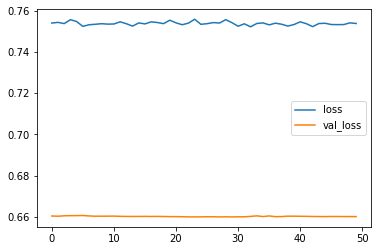

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

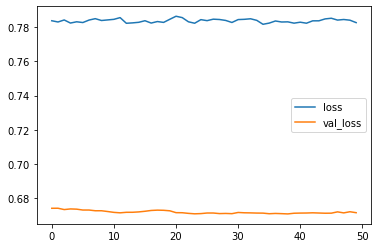

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

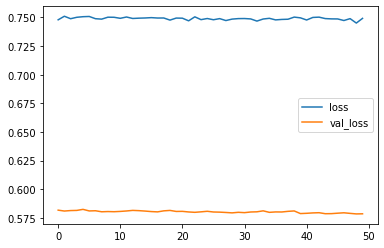

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

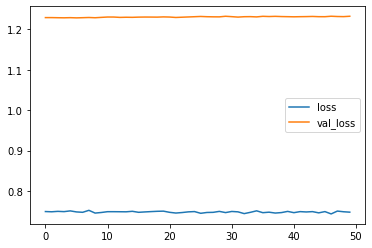

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

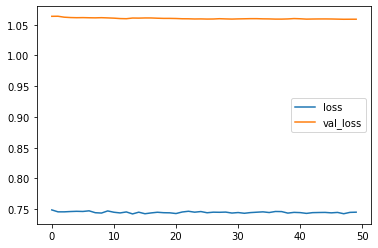

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

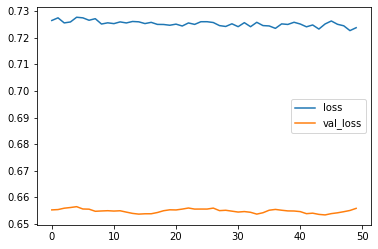

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

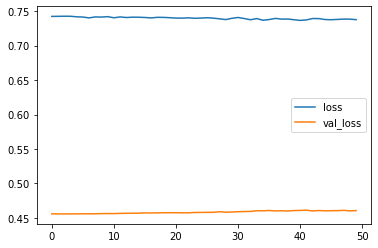

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

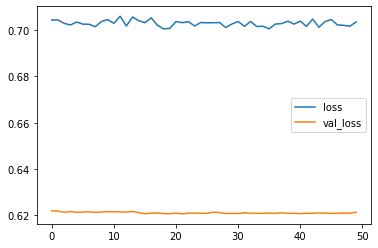

EURJPY=X
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

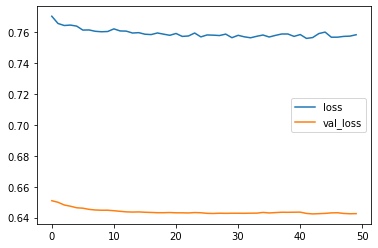

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

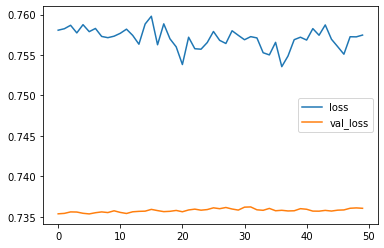

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

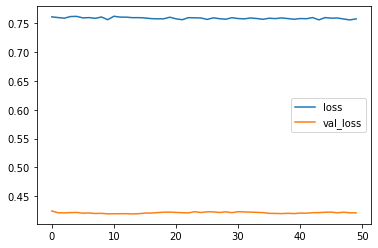

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

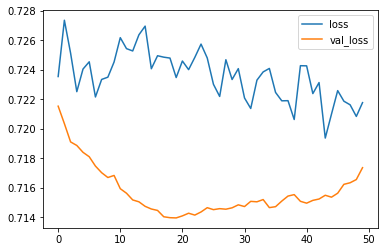

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

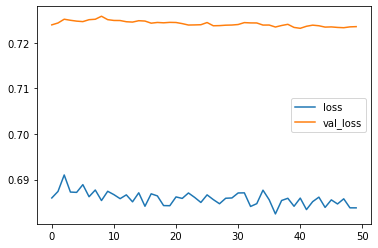

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

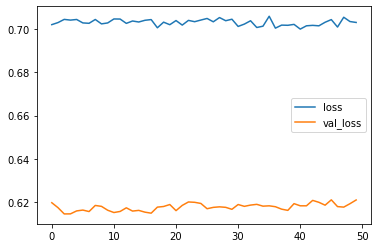

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

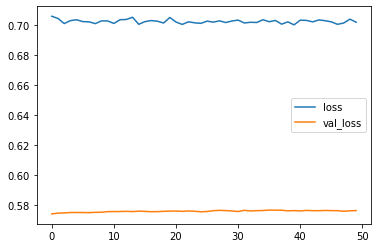

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

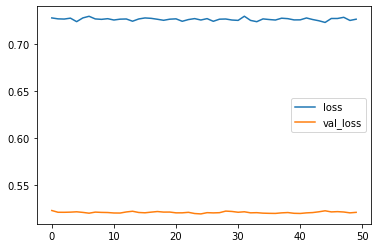

EURUSD=X
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

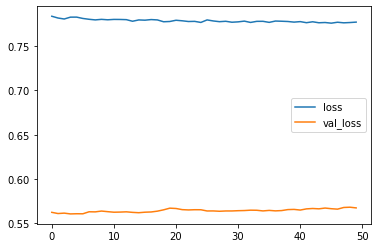

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

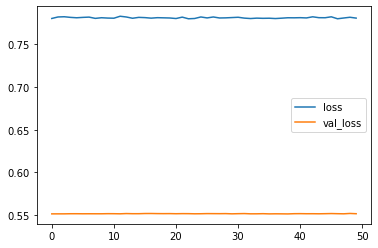

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

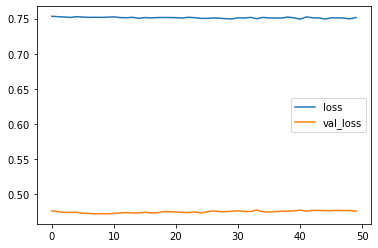

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

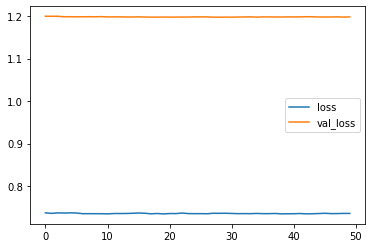

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

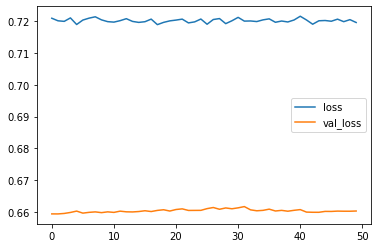

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

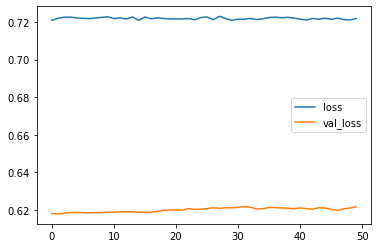

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

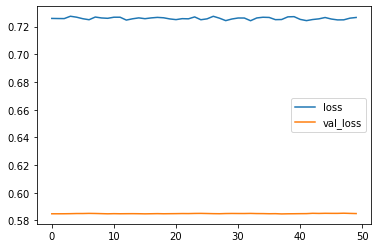

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

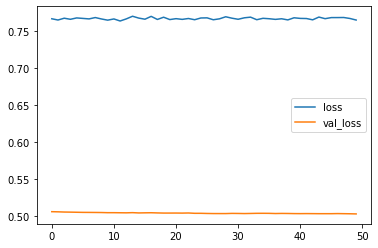

GBPJPY=X
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

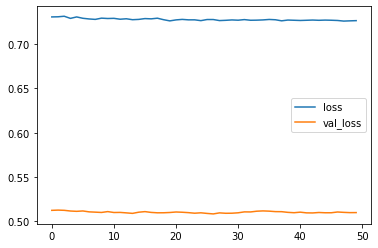

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

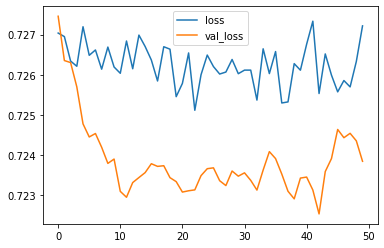

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

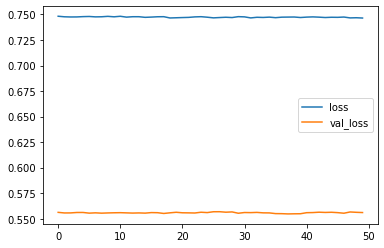

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

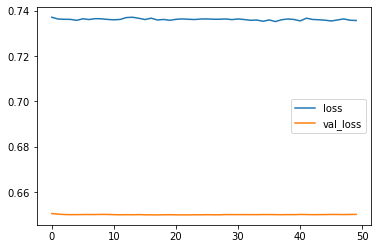

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

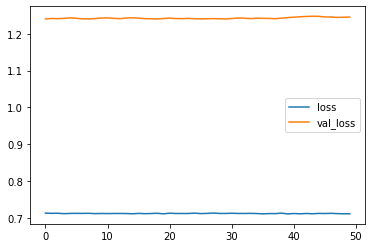

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

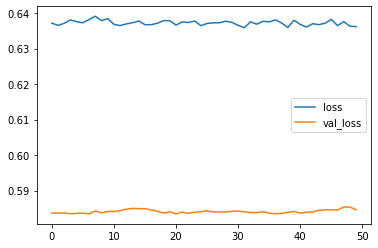

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

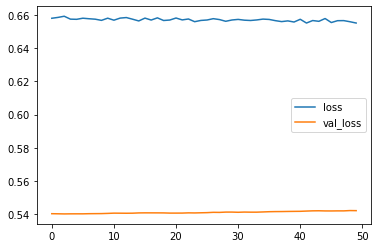

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

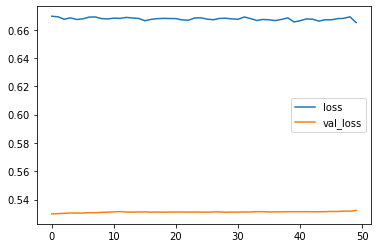

GBPUSD=X
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

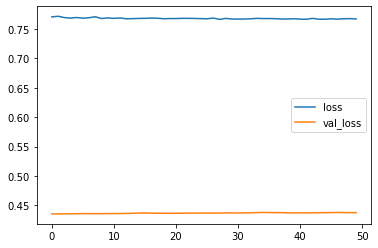

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

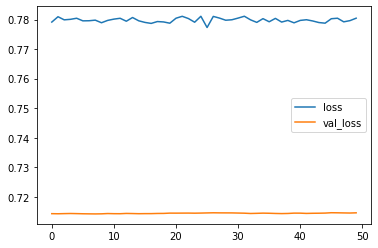

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

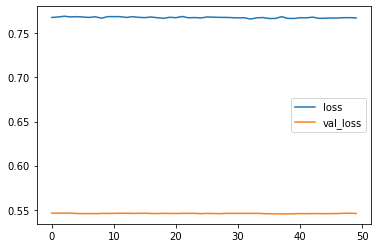

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

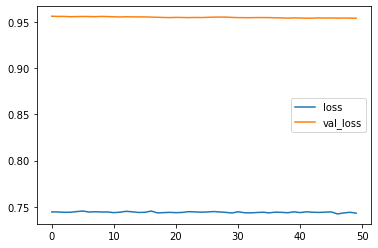

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

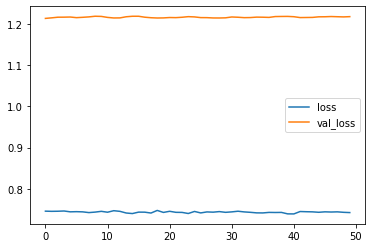

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

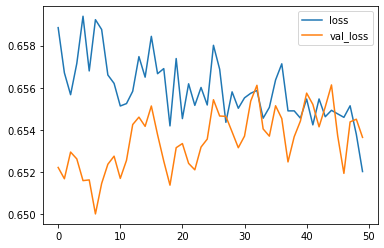

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

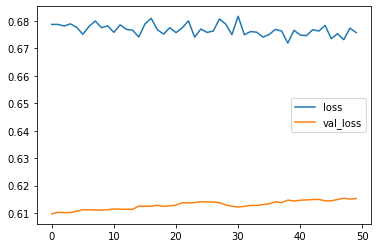

[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

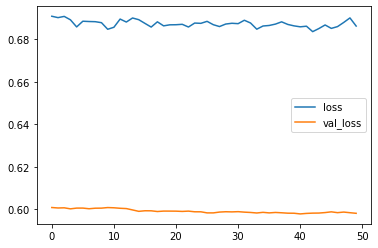

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.045339,0.659745,0.72 (0.58),0.71 (0.55)
1,1.091698,1.016944,0.72 (0.57),0.66 (0.59)
2,1.097588,0.865512,0.68 (0.58),0.67 (0.58)
3,1.110861,1.647130,0.67 (0.58),0.75 (0.59)
4,1.078252,1.547346,0.69 (0.62),0.68 (0.66)
5,1.036269,0.959797,0.70 (0.67),0.68 (0.56)
6,1.065658,0.646606,0.69 (0.63),0.71 (0.61)
7,1.031517,0.875839,0.68 (0.68),0.71 (0.70)


,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.096920,0.917230,0.69 (0.59),0.70 (0.53)
1,1.113132,1.115073,0.68 (0.58),0.66 (0.63)
2,1.131096,0.595842,0.67 (0.58),0.70 (0.65)
3,1.076418,1.052521,0.67 (0.64),0.68 (0.65)
4,1.022818,1.084531,0.67 (0.67),0.67 (0.69)
5,1.039958,0.913952,0.67 (0.68),0.68 (0.55)
6,1.055305,0.858760,0.66 (0.63),0.67 (0.59)
7,1.091656,0.712478,0.66 (0.64),0.73 (0.76)


,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.103829,0.815593,0.70 (0.56),0.69 (0.55)
1,1.106247,0.875483,0.70 (0.57),0.63 (0.56)
2,1.124170,0.714611,0.67 (0.58),0.66 (0.63)
3,1.125666,1.704232,0.65 (0.58),0.70 (0.60)
4,1.079033,0.992221,0.67 (0.64),0.66 (0.61)
5,1.065520,0.946606,0.68 (0.66),0.66 (0.52)
6,1.082116,0.844043,0.67 (0.61),0.69 (0.53)
7,1.150584,0.696528,0.66 (0.56),0.72 (0.64)


,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.074631,0.732075,0.68 (0.61),0.70 (0.59)
1,1.080595,1.039338,0.67 (0.63),0.70 (0.64)
2,1.097328,0.781560,0.68 (0.61),0.71 (0.69)
3,1.062948,0.914000,0.69 (0.64),0.71 (0.63)
4,1.013390,1.797029,0.70 (0.67),0.69 (0.80)
5,0.912444,0.865889,0.70 (0.84),0.67 (0.58)
6,0.952392,0.819481,0.69 (0.79),0.66 (0.53)
7,0.992232,0.732156,0.67 (0.75),0.73 (0.79)


,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.103403,0.619032,0.69 (0.55),0.71 (0.58)
1,1.137626,1.101885,0.68 (0.55),0.65 (0.55)
2,1.148726,0.793945,0.67 (0.55),0.69 (0.66)
3,1.113093,1.374670,0.67 (0.60),0.69 (0.58)
4,1.111962,1.739781,0.67 (0.60),0.70 (0.82)
5,0.953847,0.978817,0.68 (0.80),0.67 (0.62)
6,0.995971,0.883561,0.67 (0.74),0.69 (0.55)
7,1.008262,0.778628,0.68 (0.73),0.77 (0.69)


In [335]:
window=16
cols = ['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X']
er_data = {}
for i in range(5):
    print(er_columns[i])
    er_lstm_model_16_rolling_data = yearly_rolling_wrapper(er_lstm_model_16_ex, window, 
                                                           2009, 2016, cols, 
                                                           optimizer=tf.keras.optimizers.Adam(1e-4),  
                                                           verbose=0, epochs=50, truth_idx=i)
    er_data[er_columns[i]] = er_lstm_model_16_rolling_data

for col in cols:
    display(er_data[col])

In [352]:
for col in cols:
    print(col)
    er_data[col] = er_data[col].append(er_data[col].mean(), 'Mean')
    er_data[col] = er_data[col].append(er_data[col].std(), 'Std')
    er_data[col].index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']
    temp = er_data[col].iloc[:-2, 2:]
    for c in temp:
        data = temp[c].values
        m = np.mean([float(d[:5]) for d in data])
        std = np.std([float(d[:5]) for d in data])
        er_data[col].loc['Mean', c] = np.round(m, 3)
        er_data[col].loc['Std', c] = np.round(std, 3)
    er_data[col].columns = ['Naive(Train)', 'Naive(Val)', 'MASE-Train(Std)', 'MASE-Val(Std)']
  
    display(er_data[col].round(3))

EURGBP=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.045,0.660,0.72 (0.58),0.71 (0.55)
2013,1.092,1.017,0.72 (0.57),0.66 (0.59)
2014,1.098,0.866,0.68 (0.58),0.67 (0.58)
2015,1.111,1.647,0.67 (0.58),0.75 (0.59)
2016,1.078,1.547,0.69 (0.62),0.68 (0.66)
2017,1.036,0.960,0.70 (0.67),0.68 (0.56)
2018,1.066,0.647,0.69 (0.63),0.71 (0.61)
2019,1.032,0.876,0.68 (0.68),0.71 (0.70)
Mean,1.070,1.027,0.694,0.696
Std,0.028,0.352,0.017,0.027


EURJPY=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.097,0.917,0.69 (0.59),0.70 (0.53)
2013,1.113,1.115,0.68 (0.58),0.66 (0.63)
2014,1.131,0.596,0.67 (0.58),0.70 (0.65)
2015,1.076,1.053,0.67 (0.64),0.68 (0.65)
2016,1.023,1.085,0.67 (0.67),0.67 (0.69)
2017,1.040,0.914,0.67 (0.68),0.68 (0.55)
2018,1.055,0.859,0.66 (0.63),0.67 (0.59)
2019,1.092,0.712,0.66 (0.64),0.73 (0.76)
Mean,1.078,0.906,0.671,0.686
Std,0.035,0.171,0.009,0.021


EURUSD=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.104,0.816,0.70 (0.56),0.69 (0.55)
2013,1.106,0.875,0.70 (0.57),0.63 (0.56)
2014,1.124,0.715,0.67 (0.58),0.66 (0.63)
2015,1.126,1.704,0.65 (0.58),0.70 (0.60)
2016,1.079,0.992,0.67 (0.64),0.66 (0.61)
2017,1.066,0.947,0.68 (0.66),0.66 (0.52)
2018,1.082,0.844,0.67 (0.61),0.69 (0.53)
2019,1.151,0.697,0.66 (0.56),0.72 (0.64)
Mean,1.105,0.949,0.675,0.676
Std,0.027,0.301,0.017,0.027


GBPJPY=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.075,0.732,0.68 (0.61),0.70 (0.59)
2013,1.081,1.039,0.67 (0.63),0.70 (0.64)
2014,1.097,0.782,0.68 (0.61),0.71 (0.69)
2015,1.063,0.914,0.69 (0.64),0.71 (0.63)
2016,1.013,1.797,0.70 (0.67),0.69 (0.80)
2017,0.912,0.866,0.70 (0.84),0.67 (0.58)
2018,0.952,0.819,0.69 (0.79),0.66 (0.53)
2019,0.992,0.732,0.67 (0.75),0.73 (0.79)
Mean,1.023,0.960,0.685,0.696
Std,0.063,0.330,0.011,0.021


GBPUSD=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.103,0.619,0.69 (0.55),0.71 (0.58)
2013,1.138,1.102,0.68 (0.55),0.65 (0.55)
2014,1.149,0.794,0.67 (0.55),0.69 (0.66)
2015,1.113,1.375,0.67 (0.60),0.69 (0.58)
2016,1.112,1.740,0.67 (0.60),0.70 (0.82)
2017,0.954,0.979,0.68 (0.80),0.67 (0.62)
2018,0.996,0.884,0.67 (0.74),0.69 (0.55)
2019,1.008,0.779,0.68 (0.73),0.77 (0.69)
Mean,1.072,1.034,0.676,0.696
Std,0.069,0.343,0.007,0.033


In [356]:
print(np.mean([0.893, 0.934, 0.898]))
np.std([0.893, 0.934, 0.898])

0.9083333333333333


0.01826350337573698